# Controls scoreboard

In [6]:
import tigercontrol
import jax
import jax.numpy as np
from tigercontrol.models.optimizers import *
from tigercontrol.experiments import Experiment
import jax.random as random
from tigercontrol.utils import generate_key
import matplotlib.pyplot as plt

## Simulated Data

### Setting I: Sanity Check

We initialize an LDS with A,B,C,D, for C = I, and D = 0.
m = n = 10 are the dimensions

We start with a simple sanity check, in which we generate stationary time-series data assuming the $ARMA$ model with $AR_{dyn} = [0.6, −0.5, 0.4, −0.4, 0.3]$, $MA_{dyn} = [0.3, −0.2]$, and normally distributed noise terms $w_t ∼ N (0, 0.3^2)$.

In [7]:
ar_dyn = np.array([0.6, -0.5, 0.4, -0.4, 0.3])
ma_dyn = np.array([0.3, -0.2])
mean, noise_magnitude = 0, 0.3

m = 10
n = 10
d = 10

We will compare the models ARMA-OGD and ARMA-ONS against their boosted counterparts (with $N = 5$ weak learners). Following the experiments and results of [1], our autoregressive models use history $p = 10$ and learning rate $0.00001$.

In [15]:
def test_lqr_on_lds_control(steps=10, show_plot=True):
    T = steps
    n = 3 # input/control dimension
    m = 5 # output dimension
    d = 5 # hidden/state dimension (which is equal to output dimension here)
    problem = tigercontrol.problem("LDS-Control-v0")
    problem.initialize(n, m, d)
    F = np.zeros((d, d+n)) # system dynamics matrix
    for i in range(d):
        for j in range(d):
            F = jax.ops.index_update(F, jax.ops.index[i,j], problem.A[i][j])
    for i in range(d):
        for j in range(n):
            F = jax.ops.index_update(F, jax.ops.index[i, j+d], problem.B[i][j])

    f = np.zeros((d,1)) # bias
    C = np.identity(d+n) # quadratic cost

    c = np.zeros((d+n, 1)) # linear cost
    x = np.ones((d,1)) # initial state

    model = tigercontrol.model("LQR")
    model.initialize(F, f, C, c, T, x)

##    model2 = tigercontrol.model("GPC")
##    model2.initialize(A,B,...)

    u = model.plan()
    print(u[1].shape)
    y = []
    for i in range(steps):
        y.append(np.zeros(n))
        print(y[i].shape)
        print(problem.step(np.zeros(n)).shape)
    
    if show_plot:
        plt.plot([np.linalg.norm(i) for i in y], 'C0--', label = "LQR")
        plt.title("LQR on LDS")
        plt.legend()
        plt.show(block=False)
        plt.pause(10)
        plt.close()

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


(3, 1)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)
(3,)
(5,)


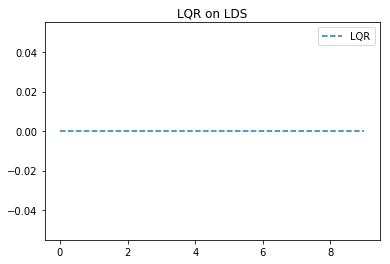

In [16]:
test_lqr_on_lds_control(10)

We can now initialize the experiment: